In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import risk_kit as erk

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

### importing data

In [4]:
ind_return = erk.get_ind_returns()
total_mkt_returns= erk.get_total_market_index_returns()

In [10]:
risky_r = ind_return['2000':][['Steel','Fin','Beer']]
#create a dataframe equaly shaped
safe_r = pd.DataFrame().reindex_like(risky_r)

In [12]:
safe_r[:] = 0.03/12

In [14]:
start = 1000
floor = 0.8

## CPPI
1. Cushion : (Asset value - Floor Value)
2. Compute an Allocation to Safe and Risky Assets => m * risk budget
3. Recompute the Asset Value Based on the Returns

### using timeit() to verify efficiency

In [37]:
def compound_1(r):
    return (1+r).prod() -1

def compound_2(r):
    return np.expm1(np.log1p(r).sum())

In [35]:
%timeit compound_1(risky_r)

375 µs ± 8.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
%timeit compound_2(risky_r)

367 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## set up

In [44]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

In [50]:
for step in range(n_steps):
    cushion = (account_value-floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0)
    safe_w = 1-risky_w
    
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    ##update account value for each time step
    
    account_value = (risky_alloc*(1+risky_r.iloc[step])) + (safe_alloc*(1+safe_r.iloc[step]))
    #save the values to see the history
    
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    

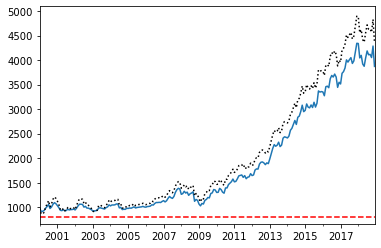

In [71]:
risky_wealth = start*(1+risky_r).cumprod()
#risky_wealth.plot()
ax = account_history['Beer'].plot()
risky_wealth['Beer'].plot(ax=ax, style = 'k:' ) #same axis
ax.axhline(y=floor_value, color='r', linestyle='--')

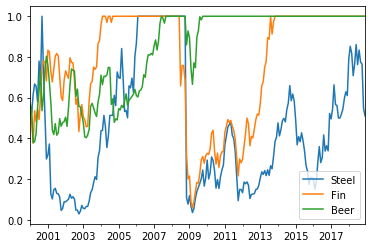

In [74]:
risky_w_history.plot()

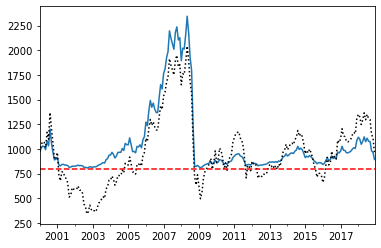

In [75]:
ind = 'Steel'
risky_wealth = start*(1+risky_r).cumprod()
#risky_wealth.plot()
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style = 'k:' ) #same axis
ax.axhline(y=floor_value, color='r', linestyle='--')

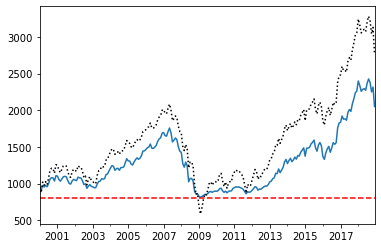

In [76]:
ind = 'Fin'
risky_wealth = start*(1+risky_r).cumprod()
#risky_wealth.plot()
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style = 'k:' ) #same axis
ax.axhline(y=floor_value, color='r', linestyle='--')

In [81]:
erk.summary_results(risky_r)

,Annualized Return,Annualized vol,Skewness,Kurtosis,Cornish-Fisher Value at Risk (5%),Historic CVar (5%),Sharpe Ratio,Annualized Sharp,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368,-0.271368


In [83]:
btr = erk.run_cppi(risky_r)

In [89]:
erk.summary_results(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized vol,Skewness,Kurtosis,Cornish-Fisher Value at Risk (5%),Historic CVar (5%),Sharpe Ratio,Annualized Sharp,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582,-0.259582


### Resuming 

#### without updating drawndown

In [94]:
return_without = erk.run_cppi(risky_r)

,Annualized Return,Annualized vol,Skewness,Kurtosis,Cornish-Fisher Value at Risk (5%),Historic CVar (5%),Sharpe Ratio,Annualized Sharp,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582,-0.259582


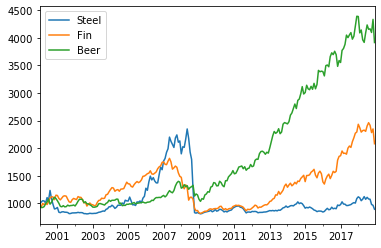

In [111]:
return_without['Wealth'].plot()

erk.summary_results(return_without['Wealth'].pct_change().dropna())

In [114]:
return_with = erk.run_cppi(risky_r, drawdown= 0.8)

,Annualized Return,Annualized vol,Skewness,Kurtosis,Cornish-Fisher Value at Risk (5%),Historic CVar (5%),Sharpe Ratio,Annualized Sharp,Max Drawdown
Steel,-0.001320,0.312973,-0.330333,4.132666,0.150415,0.208117,-0.097801,-0.758017,-0.758017
Fin,0.057941,0.192986,-0.543630,5.015294,0.091172,0.132175,0.140661,-0.718465,-0.718465
Beer,0.082286,0.139058,-0.502368,4.181533,0.063037,0.091442,0.365788,-0.271368,-0.271368


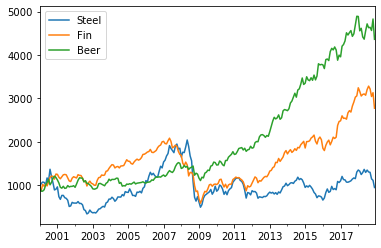

In [115]:
return_with['Wealth'].plot()
erk.summary_results(return_with['Wealth'].pct_change().dropna())